# Understanding Customer Sentiments Towards Airlines 

By Hannah Koschmeder, Sophia Yoo, Bryan Yan

## Introduction



In [133]:
import numpy as np
import pandas as pd
import math
import csv
from textblob import TextBlob
import re
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))


## Getting the Data

Although Twitter has an official API, it is annoying to work with and has many limitations. Because of this, we will be using an official scraper, which can be found [here](https://github.com/taspinar/twitterscraper). Run the following commands for each airline to retrieve the results that we will be using:

`pip install twitterscraper`

` twitterscraper "to:united" -o united.csv -l 5000 -c`

We chose to look at the top 7 airlines within North America.
* Alaska Airlines
* American Airlines
* Delta Airlines
* JetBlue Airlines
* SouthWest Airlines
* Spirit Airlines
* United Airlines

Using the `twitterscraper`, we scraped 5000 tweets to or mentioning the airlines mentioned above. 

In [134]:
import numpy as np
import pandas as pd

airline_df = pd.DataFrame()
airlines = ['alaska', 'american', 'delta', 'jetblue', 'southwest', 'spirit', 'united']
filenames = ["../data/alaska.csv", "../data/american.csv",
             "../data/delta.csv", "../data/jetblue.csv",
             "../data/southwest.csv", "../data/spirit.csv",
             "../data/united.csv"]

for filename in filenames:
    file = pd.read_csv(filename)
    file['airline'] = filename.split('../data/')[1][:-4]
    airline_df = airline_df.append(file)

airline_df = airline_df.drop(['url','html'], axis=1)

### Data Cleaning

Before we move onto sentiment analysis, we need to clean the tweets to remove hashtags, tags, urls, and punctuation for better accuracy on sentiment.

In [135]:
import re
import string

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_tags(text):
    return re.sub(r'#\w+', '', text)

def remove_urls(text):
    result = re.sub(r'https://[^\s]+[\s]?', '', text)
    result = re.sub(r'http://[^\s]+[\s]?', '', text)
    result = re.sub(r'www.[^\s]+[\s]?', '', text)
    return re.sub(r'[^\s]+.com\S[\w]+', '', text)

def remove_punctuation(text):
    punc = string.punctuation
    trans = str.maketrans(punc, len(punc)* ' ')
    return text.translate(trans)

def clean_tweet(tweet):    
    noURLs = remove_urls(tweet)
    noMentions = remove_mentions(noURLs)
    noTags = remove_tags(noMentions)
    noPunct = [remove_punctuation(text) for text in noTags.split(' ')]    
    return ' '.join(noPunct).lower().strip()

airline_df['text'] = airline_df['text'].apply(lambda x: clean_tweet(str(x)))
airline_df['text'].replace('', np.nan, inplace=True)
airline_df['timestamp'] = airline_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
airline_df.dropna(subset=['text'], inplace=True)
airline_df.head()

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13,0,0,0,3rd cancelled flight of my vacay now just hu...,alaska
2,mr_deals805,o,841411760015859714,2017-03-13,0,0,0,people from kansas city not people from san ...,alaska
3,lilcadet101,Cadet,841409697089486849,2017-03-13,0,0,0,i ll take an 800 voucher to give up my seat f...,alaska
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13,0,0,0,hands down the best airline in customer servi...,alaska
5,jaustinw,J. Austin Wulliman,841406203695587328,2017-03-13,1,1,0,wait how could you tell i was blazed when i t...,alaska


### Sentiment Classification

To get the sentiments of every tweet, we will be using a library called [TextBlob](http://textblob.readthedocs.io/en/dev/index.html). `TextBlob` gives us a sentiment polarity from -1 to 1 based on the words. We classified the sentiment of the tweet based on the polarity score we got from the tweet.

In [136]:
from textblob import TextBlob

def get_sentiment(text):
    tb = TextBlob(str(text))
    return tb

def getClassification(polarity):
    if (polarity < 0): return 'negative'
    elif (polarity > 0): return 'positive'
    else: return 'neutral'
    

airline_df['sentiment_polarity'] = airline_df['text'].apply(lambda x: get_sentiment(x).sentiment.polarity)
airline_df['sentiment'] = airline_df['sentiment_polarity'].apply(lambda x: getClassification(x))
airline_df.tail()

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment
5195,griffinhill1997,Griffinator,576734335774126080,2015-03-14,0,0,0,i just wasted almost 10 on your shitty wifi,united,-0.20,negative
5196,houseofpickles,Rhia,576732782266839041,2015-03-14,0,1,0,thanks you guys need to work out some better ...,united,0.35,positive
5197,katiesmiledoc,Katie Graber,576731313178312704,2015-03-14,0,0,0,just replied via dm thanks for the rapid resp...,united,0.20,positive
5198,huntmayo,Hunt Mayo,576730512221302784,2015-03-14,0,0,0,pushing back … 0nyivaeh18,united,0.00,neutral
5199,ashknierim,Ashley Knierim,576728675367927808,2015-03-14,0,0,0,when do you post last minute weekend deals,united,0.00,neutral


## Exploratory Data Analysis 

balhblah

### Sentiment Distribution

blah blah blah

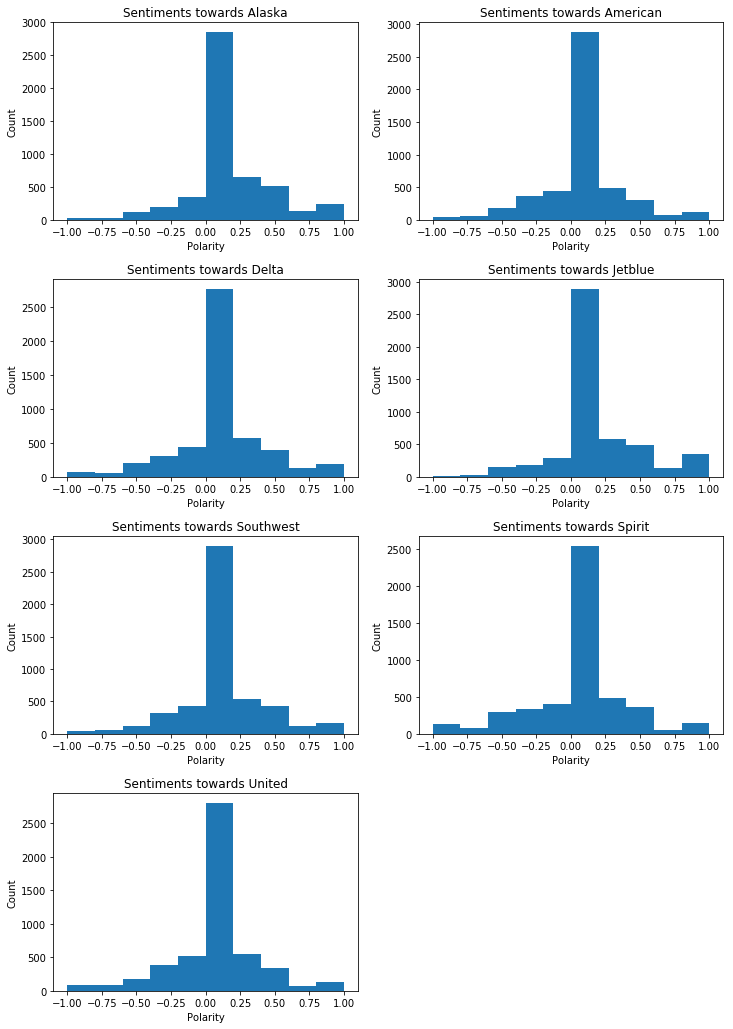

In [86]:
def plot_histogram(df, airline, name, xlabel):
    subset = df[df['airline'] == airline]
    allValues = subset[name]
    plt.hist(allValues)
    plt.title('Sentiments towards ' + airline.capitalize())
    plt.xlabel(xlabel)
    plt.ylabel('Count')

plt.figure(figsize=(12,32))
name = 'sentiment_polarity'
label = 'Polarity'

for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.3)
    plot_histogram(airline_df, airline, name, label)

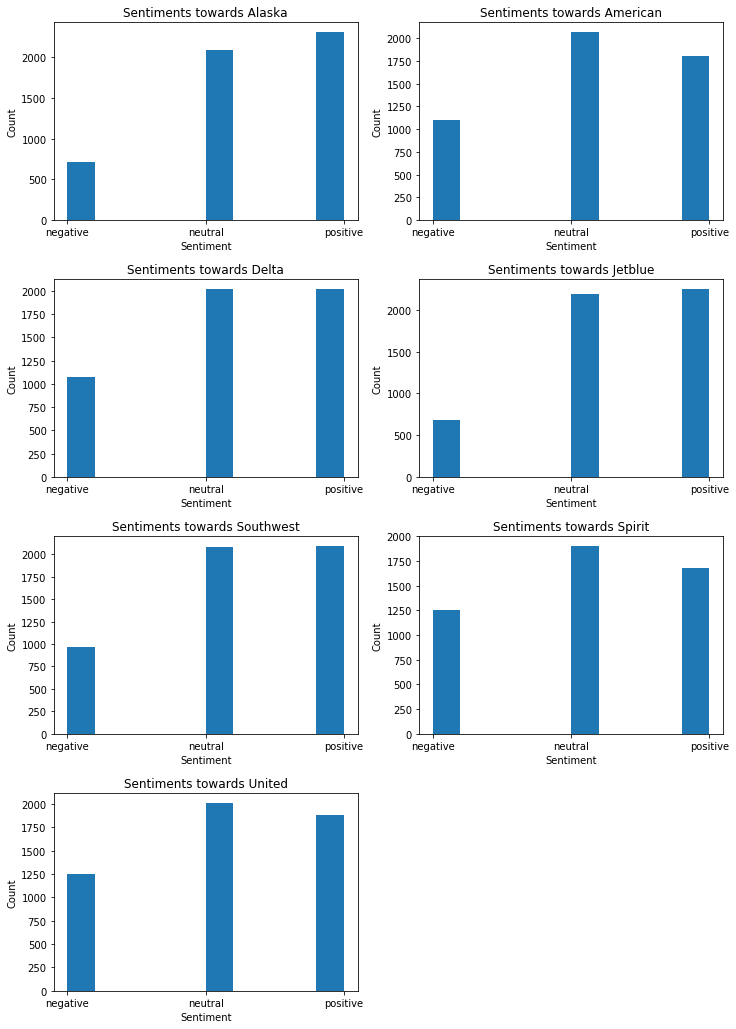

In [78]:
plt.figure(figsize=(12,32))
name = 'sentiment'
label = 'Sentiment'

for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.3)
    plot_histogram(airline_df, airline, name, label)

### Time Series Observations

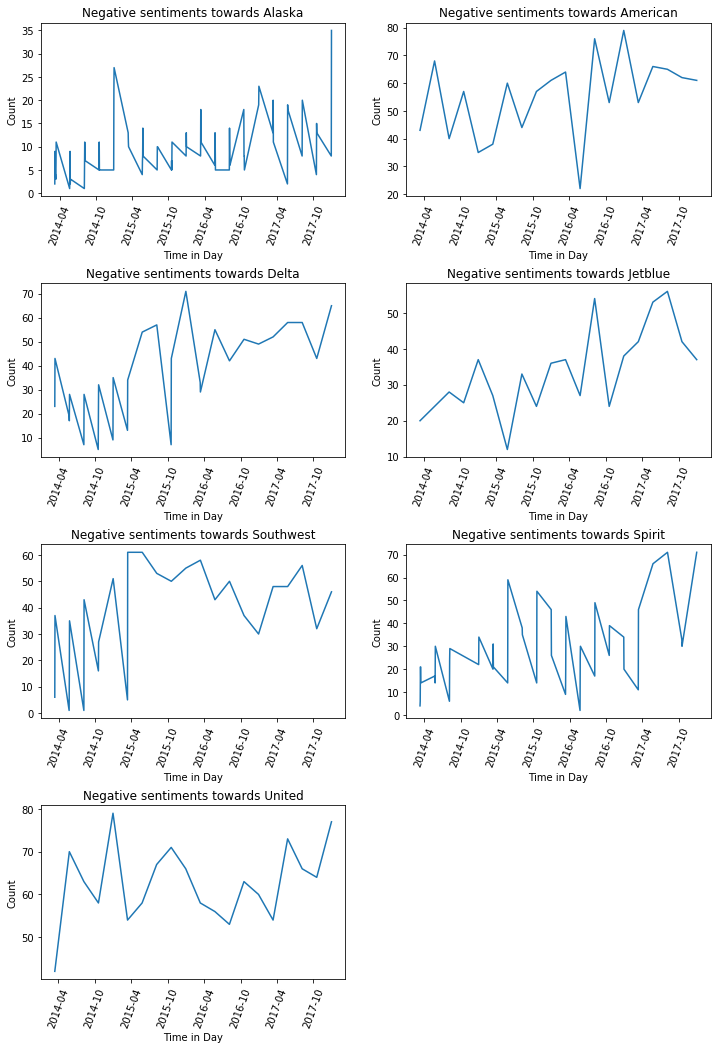

In [79]:
#plot negative tweets over time by airline
def plotTimeSeries(df, airline, sentiment, day=True):
    subset = df[df['airline'] == airline]
    subset = subset[subset['sentiment'] == sentiment]
    xlab = "Day"
    if not day:
            subset['timestamp'] = subset['timestamp'].apply(lambda x: x.replace(day=1))
            xlab = "Months"
    allValues = pd.DataFrame({'timestamp':subset['timestamp'],'counts':subset['timestamp']})
    allValues = allValues.groupby('timestamp').count()
    plt.plot(allValues.index, allValues['counts'])
    plt.title(sentiment.capitalize() + ' sentiments towards '  + airline.capitalize())
    plt.xticks(rotation=70)
    plt.xlabel("Time in " + xlab)
    plt.ylabel('Count')

plt.figure(figsize=(12,32))
name = 'negative'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.5)
    plotTimeSeries(airline_df, airline, name, True)

### Tweet Word Cloud

blah blah blahhh

In [109]:
from textblob import TextBlob

def generate_wordclouds(df, colname, stopwords):
    unique = list(pd.unique(df[colname]))
    wordclouds = dict()
    for i, value in enumerate(unique):
        subset = df.loc[df[colname] == value]
        wc = WordCloud(width = 800, height = 600, max_words = 70,
                       background_color='white', stopwords=stopwords).generate(str(subset['text']))
        wordclouds[value] = wc
    return wordclouds

def plot_image(im):
    plt.imshow(np.asarray(im))
    
tweet_stopwords = set(['thank', 'thanks', 'airline', 'flight', 'airline', 'plane', 'airlines', 'alaska',
                      'americanairlines', 'delta', 'united' , 'alaskaairlines', 'southwest', 'unitedairlines', 'jetblue',
                      'twitter', 'get'])
stopwords = set(stop_words | tweet_stopwords)
sentiment_wcs = generate_wordclouds(airline_df, 'sentiment', stopwords)
airline_wcs = generate_wordclouds(airline_df, 'airline', stopwords)

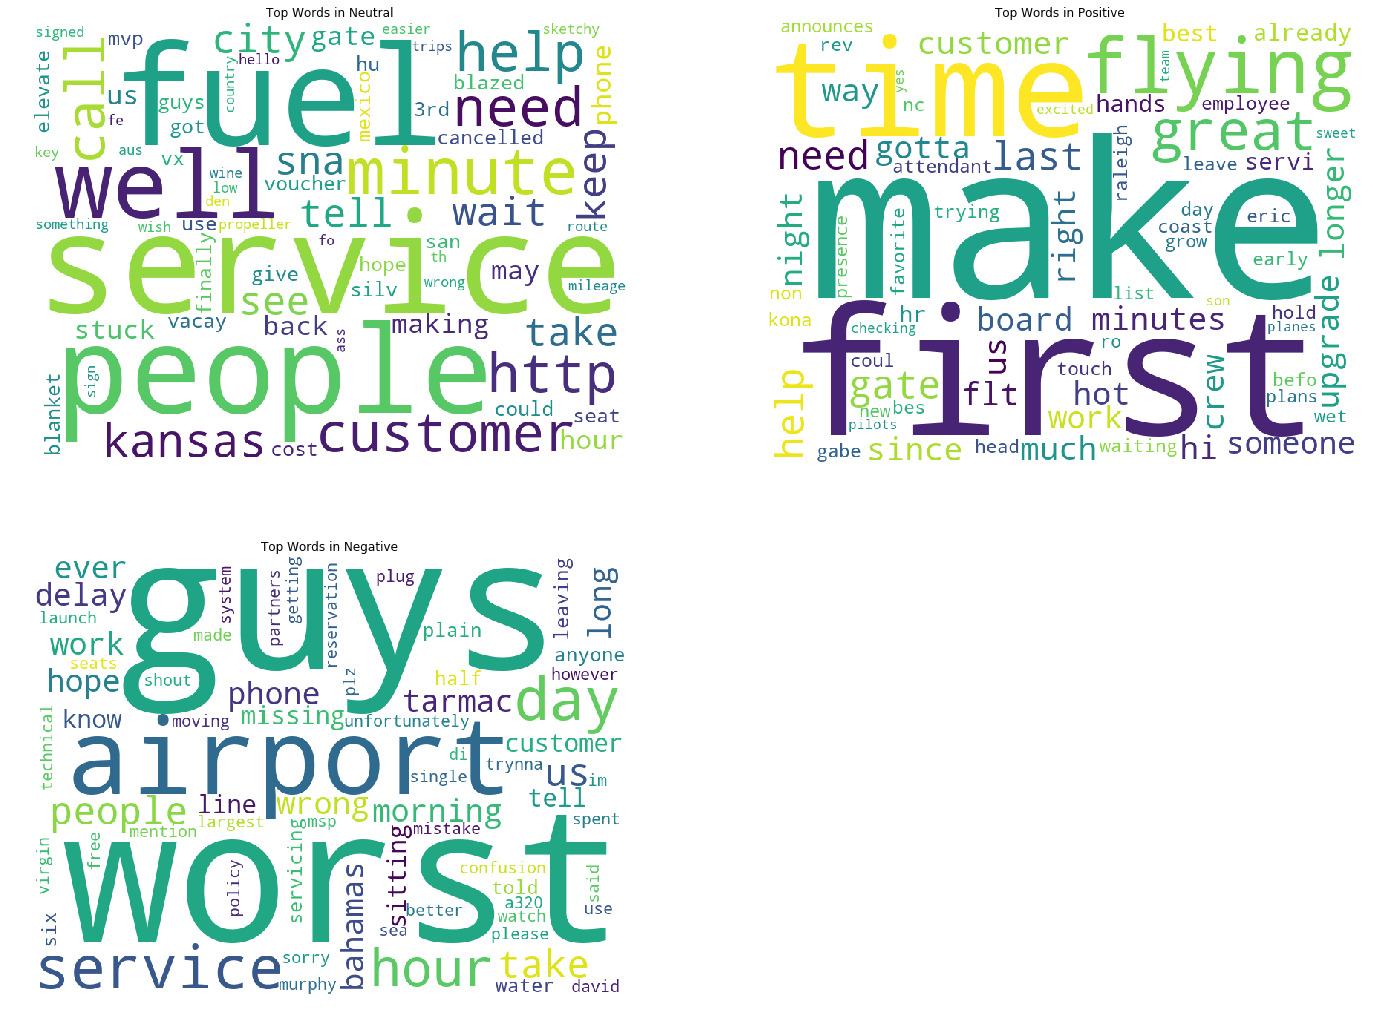

In [110]:
plt.figure(figsize=(24, 18))
i = 0

for sentiment, wc in sentiment_wcs.items():
    plt.subplot(2, 2, i+1)
    plt.title("Top Words in " + sentiment.capitalize())
    plt.axis('off')
    plot_image(wc)
    i += 1

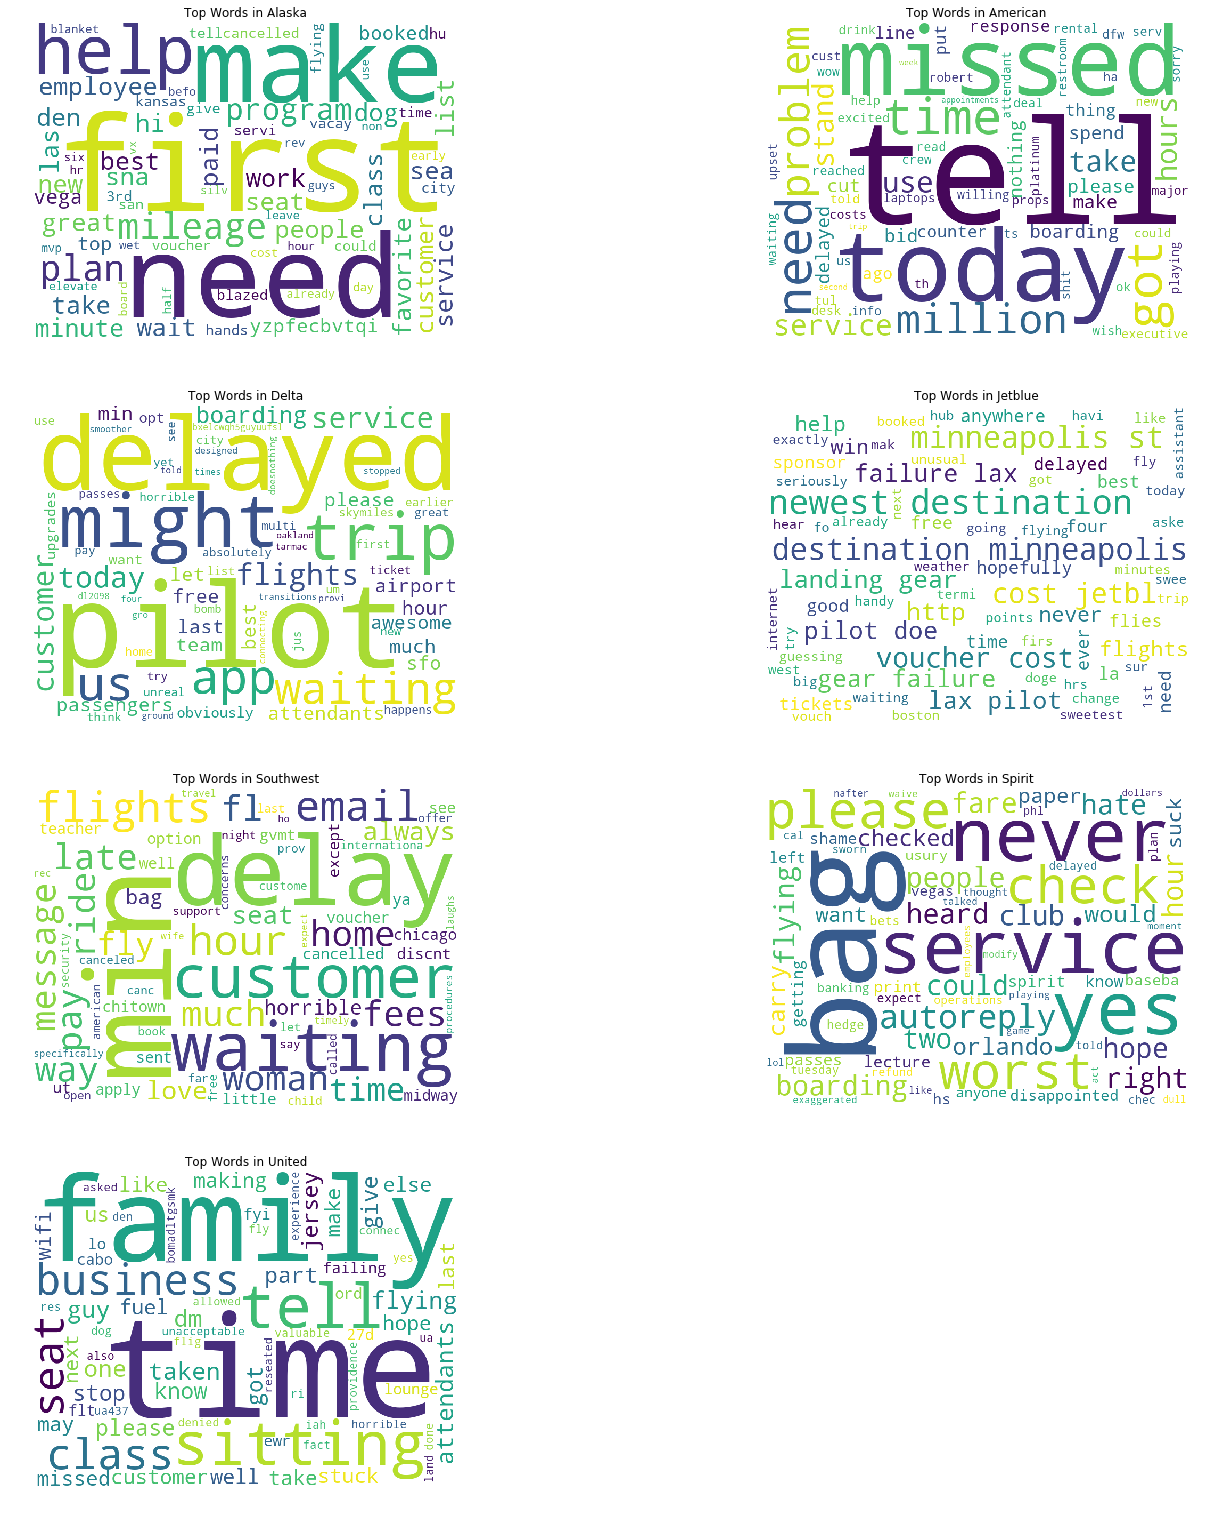

In [111]:
plt.figure(figsize=(24, 27))
i = 0
for sentiment, wc in airline_wcs.items():
    plt.subplot(4, 2, i+1)
    plt.title("Top Words in " + sentiment.capitalize())
    plt.axis('off')
    plot_image(wc)
    i += 1

## Clustering and Classifying Tweets

### Data Preparation

* tokenize 
* split train + test set

In [138]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def remove_numbers(text):
    return re.sub(r'[\d]', '', text)

def process_tokens(tweet):
    noNumbers = remove_numbers(tweet)
    tokens = nltk.word_tokenize(noNumbers)
    filtered_words = [word for word in tokens if (word not in stop_words)]
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_words]
    non_stop = [re.sub('[^A-Za-z0-9]+', '', lemma) for lemma in lemmas if (lemma not in add_stop and lemma != "http")]
    final = [word for word in non_stop if len(word) > 2]
    return final

airline_df['tokens'] = airline_df['text'].apply(lambda x: process_tokens(x))
airline_df.head()

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment,tokens
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13,0,0,0,3rd cancelled flight of my vacay now just hu...,alaska,0.000000,neutral,"[cancelled, vacay, hung, holding, min, merger,..."
2,mr_deals805,o,841411760015859714,2017-03-13,0,0,0,people from kansas city not people from san ...,alaska,0.000000,neutral,"[kansa, san, francisco]"
3,lilcadet101,Cadet,841409697089486849,2017-03-13,0,0,0,i ll take an 800 voucher to give up my seat f...,alaska,0.000000,neutral,"[voucher, give, seat, boston, san, diego]"
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13,0,0,0,hands down the best airline in customer servi...,alaska,0.422222,positive,"[hand, best, customer, service, planet]"
5,jaustinw,J. Austin Wulliman,841406203695587328,2017-03-13,1,1,0,wait how could you tell i was blazed when i t...,alaska,0.000000,neutral,"[wait, could, blazed, tweeted]"


### Training Doc2Vec Model

We will be using the `gensim` library in Python to train a Doc2Vec model. In order to do so, we need to create a list of `TaggedDocument`s, which are in the format `[word = [token1, token2, token3, ..], tags = [tag]]`. We feed a list of `TaggedDocument`s to the model, and train it.

In [139]:
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

TaggedTweet = gensim.models.doc2vec.TaggedDocument
tweets = [TaggedTweet(x, [i]) for i, x in enumerate(airline_df['tokens'])]
model = Doc2Vec(min_count=1, window=10, vector_size=100, sample=1e-4, workers=8)
model.build_vocab(tweets)

# model = Doc2Vec(vector_size=100, dbow_words= 1, dm=0, epochs=100,  window=5, seed=1337, min_count=5, workers=4,alpha=0.025, min_alpha=0.025)
### OLD
pos_tokens = list(airline_df.loc[airline_df['sentiment'] == "positive"]['tokens'])
# neg_tokens = list(airline_df.loc[airline_df['sentiment'] == "negative"]['tokens'])

# pos_labs = list(airline_df.loc[airline_df['sentiment'] == "positive"]['airline'])
# neg_labs = list(airline_df.loc[airline_df['sentiment'] == "negative"]['airline'])

# TaggedTweet1 = gensim.models.doc2vec.TaggedDocument
# TaggedTweet2 = gensim.models.doc2vec.TaggedDocument

# PosTweets = [TaggedTweet1(x, [pos_labs[i]]) for i, x in enumerate(pos_tokens)]
# NegTweets = [TaggedTweet2(x, [neg_labs[i]]) for i, x in enumerate(neg_tokens)]

In [125]:
total = len(tweets)
model.train(tweets, total_examples=total, epochs = 10, start_alpha=0.002, end_alpha=-0.016)

In [142]:
model.wv.most_similar('seat')

[('woot', 0.3870909810066223),
 ('attnd', 0.36674797534942627),
 ('reply', 0.35301899909973145),
 ('fala', 0.3461824953556061),
 ('prince', 0.34350907802581787),
 ('homehttp', 0.3407153785228729),
 ('preboarding', 0.32770588994026184),
 ('happens', 0.3236737847328186),
 ('revealed', 0.3230154812335968),
 ('dentro', 0.3206123113632202)]

In [148]:
# duplicate_dict = {}
# used_lines = []
# for i, t in enumerate(lines):
#     if i % 2 == 0 and t not in duplicate_dict:
#         duplicate_dict[t] = True
#         used_lines.append(t)
#         vectors.append(model.infer_vector(preprocess_document(t)))

# print("done")

model.dbow_words

NameError: name 'KMeansClusterer' is not defined

In [188]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=6, init='k-means++', max_iter=100)  
X = kmeans_model.fit(model.docvecs.vectors_docs)
labels=kmeans_model.labels_.tolist()

# try predicting
l = kmeans_model.fit_predict(model.docvecs.vectors_docs)

0

In [196]:
def get_cluster_tweets(clust):
    res = []
    for i in range(len(labels)):
        if labels[i] == clust:
            res.append(i)
    return res

def get_words(tweets, cluster_labs):
    res = []
    for i in cluster_labs:
        res += tweets[i]
    return res

cluster1_words = get_words(list(airline_df['tokens']), get_cluster_tweets(1))

['voucher',
 'give',
 'seat',
 'boston',
 'san',
 'diego',
 'hand',
 'best',
 'customer',
 'service',
 'planet',
 'unfortunately',
 'however',
 'indicated',
 'deliver',
 'area',
 'danville',
 'sorry',
 'confusion',
 'sweet',
 'pilot',
 'son',
 'orlando',
 'pilot',
 'first',
 'flying',
 'together',
 'duo',
 'likely',
 'tomorrow',
 'going',
 'delayed',
 'cancelled',
 'always',
 'help',
 'listening',
 'hey',
 'continue',
 'knock',
 'park',
 'overall',
 'service',
 'inflight',
 'crew',
 'booked',
 'tix',
 'milk',
 'run',
 'flts',
 'row',
 'correctly',
 'aligned',
 'window',
 'sent',
 'thank',
 'got',
 'notification',
 'departing',
 'instead',
 'need',
 'rush',
 'airport',
 'buy',
 'plane',
 'fly',
 'even',
 'better',
 'hey',
 'guy',
 'recently',
 'cancelled',
 'said',
 'send',
 'voucher',
 'missed',
 'received',
 'help',
 'everything',
 'wrong',
 'since',
 'merger',
 'friend',
 'sure',
 'case',
 'bless',
 'andre',
 'loving',
 'anti',
 'family',
 'vacay',
 'tweet',
 'find',
 'sure',
 'board